In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import math
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load the Images and Labels

In [3]:
train_image_paths = []
train_image_labels = []
test_image_paths = []
test_image_labels = []

classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
mapping = {
    "buildings": 0,
    "forest": 1,
    "glacier": 2,
    "mountain": 3,
    "sea": 4,
    "street": 5
}

data_root = "/kaggle/input/intel-image-classification/seg_train/seg_train"
for i in range(len(classes)):
    filepath = os.path.join(data_root, classes[i])
    for filename in os.listdir(filepath):
        if filename.endswith('jpg'):
            train_image_paths.append(os.path.join(filepath, filename))
            train_image_labels.append(i)

data_root = "/kaggle/input/intel-image-classification/seg_test/seg_test"
for i in range(len(classes)):
    filepath = os.path.join(data_root, classes[i])
    for filename in os.listdir(filepath):
        if filename.endswith('jpg'):
            test_image_paths.append(os.path.join(filepath, filename))
            test_image_labels.append(i)

In [4]:
len(train_image_paths), len(train_image_labels), len(test_image_paths), len(test_image_labels)

(14034, 14034, 3000, 3000)

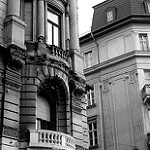

In [5]:
Image.open(train_image_paths[1434])

# Dataset and DataLoader

## Define Dataset and DataLoader

In [6]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as v2

In [7]:
to_tensor_transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True), 
    v2.Resize((128, 128)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
%%time
to_tensor_transform(Image.open(train_image_paths[2])).shape

CPU times: user 29.1 ms, sys: 5.85 ms, total: 34.9 ms
Wall time: 63.9 ms


torch.Size([3, 128, 128])

In [9]:
class Img_Dataset(Dataset):
    def __init__(self, filepaths, labels, transforms=None):
        self.transforms = transforms
        self.labels = labels
        self.imgs = filepaths

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = to_tensor_transform(Image.open(self.imgs[idx]))
        if self.transforms is None:
            return img, self.labels[idx]
        return self.transforms(img), self.labels[idx]

## Split the Data

In [10]:
# from sklearn.model_selection import train_test_split

In [11]:
# train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, image_labels, test_size=0.2)

In [12]:
# len(train_paths), len(train_labels)

## Creat the Datasets and DataLoaders

In [13]:
train_transform = v2.Compose([
    v2.TrivialAugmentWide(),
    # v2.RandomRotation(15),
    # v2.RandomAffine(45),
    # v2.ElasticTransform()
])

In [14]:
train_ds = Img_Dataset(train_image_paths, train_image_labels, train_transform)
train_loader = DataLoader(
    train_ds,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [15]:
test_ds = Img_Dataset(test_image_paths, test_image_labels, None)
test_loader = DataLoader(
    test_ds,
    batch_size=512,
    shuffle=False,
    num_workers=4,
)

In [16]:
%%time
for imgs, labels in train_loader:
    print(imgs.shape)
    print(labels.shape)
    break

torch.Size([256, 3, 128, 128])
torch.Size([256])
CPU times: user 9.03 ms, sys: 56.4 ms, total: 65.4 ms
Wall time: 6.56 s


## Train and Test Functions

In [17]:
def train(model, criteria, optimiser, scheduler=None):
    model.train()
    total_loss = 0.0
    itr_cnt = 0
    num_correct = 0
    cnt = 0
    cutmix = v2.CutMix(num_classes=len(classes))
    mixup = v2.MixUp(num_classes=len(classes))
    cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
    for imgs, labels in (pbar := tqdm(train_loader)):
        imgs, labels = imgs.to(device), labels.to(device)
        # imgs, labels = cutmix_or_mixup(imgs, labels)
        optimiser.zero_grad()
        output = model(imgs)
        loss = criteria(output, labels)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
        itr_cnt += 1
        cnt += labels.shape[0]
        num_correct += sum(output.argmax(-1) == labels)
        # num_correct += sum(output.argmax(-1) == labels.argmax(-1))
        pbar.set_description(f"Average Loss: {total_loss / itr_cnt :6f} | Train Accuracy: {num_correct / cnt * 100 :6f}")
    if scheduler is not None:
        scheduler.step()

In [18]:
def test(model, criteria, optimiser=None, scheduler=None):
    model.eval()
    total_loss = 0.0
    itr_cnt = 0
    num_correct = 0
    cnt = 0
    with torch.no_grad():
        for imgs, labels in (pbar := tqdm(test_loader)):
            imgs, labels = imgs.to(device), labels.to(device)
            output = model(imgs)
            loss = criteria(output, labels)
            total_loss += loss.item()
            itr_cnt += 1
            cnt += labels.shape[0]
            num_correct += sum(output.argmax(-1) == labels)
            pbar.set_description(f"Average Loss: {total_loss / itr_cnt :6f} | Test Accuracy: {num_correct / cnt * 100 :6f}")

# Model Definition

In [19]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True # Remember to add this line!!!!

## ResNet

In [20]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=1, stride=stride)
        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.silu(self.conv0(x))
        x1 = F.silu(self.bn1(self.conv1(x)))
        x1 = F.silu(self.bn2(self.conv2(x1)))
        return x1 + x

In [21]:
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = nn.Sequential(
            ResNetBlock(3, 8, 1),
            ResNetBlock(8, 16, 2),
            ResNetBlock(16, 32, 2),
            ResNetBlock(32, 64, 2),
            ResNetBlock(64, 128, 2),
            ResNetBlock(128, 128, 1),
        )

        self.pool = nn.AdaptiveMaxPool2d((6, 6))
        self.flatten = nn.Flatten()
        # self.fc = nn.Linear(128 * 8 * 8, num_classes)
        self.fc = nn.Sequential(
            nn.Linear(128 * 6 * 6, 128),
            nn.GELU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc(x)

In [22]:
resnet_model = ResNet(len(classes)).to(device)
resnet_criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
# resnet_optimiser = optim.SGD(resnet_model.parameters(), lr=1e-3, momentum=0.9)
resnet_optimiser = optim.AdamW(resnet_model.parameters(), lr=4e-4)
resnet_scheduler = optim.lr_scheduler.ExponentialLR(resnet_optimiser, gamma=0.9)

In [23]:
sum(p.numel() for p in resnet_model.parameters())

1525942

In [24]:
for _ in range(20):
    train(resnet_model, resnet_criteria, resnet_optimiser, resnet_scheduler)
    test(resnet_model, resnet_criteria, resnet_optimiser, resnet_scheduler)

  0%|          | 0/55 [00:03<?, ?it/s]


KeyboardInterrupt: 

## Vanilla ViT

In [25]:
class PatchImage(nn.Module):
    def __init__(self, in_channels, width, height, p_size, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=(3, 3), padding=1, stride=1),
            nn.BatchNorm2d(6),
            nn.SiLU(),
            nn.Conv2d(6, 6, kernel_size=(3, 3), padding=1, stride=1),
            nn.BatchNorm2d(6),
            nn.SiLU(),
        )

        self.to_patch = nn.Sequential(
            nn.Conv2d(6, hidden_dim, kernel_size=(p_size, p_size), stride=p_size, padding=0, bias=False, groups=6),
            nn.BatchNorm2d(hidden_dim),
        )

        num_w = width // p_size
        num_h = height // p_size
        self.num_patches = num_w * num_h
        grid_w, grid_h = torch.meshgrid(torch.arange(num_w) + 1, torch.arange(num_h) + 1)
        grid = grid_w + grid_h
        grid = grid.unsqueeze(-1).repeat(1, 1, hidden_dim)
        scaling = torch.arange(hidden_dim) + 1
        scaling = scaling.unsqueeze(0).unsqueeze(0) / math.sqrt(width)
        pos_embed = torch.sin(grid * scaling).unsqueeze(0).permute(0, 3, 1, 2) # unsqueeze for batch size
        self.pos_embedding = nn.Parameter(pos_embed)
        self.embed_weight = nn.Parameter(torch.tensor(0.05)) # REMEMBER TO ADD THIS
        # IF NOT THE ORIGINAL IMAGE'S SIGNAL WILL BE MASKED

    def forward(self, x):
        x = self.pre_conv(x)
        # x: [batch size, 16, width, height]
        # print(self.to_patch(x).shape)
        # print(self.pos_embedding.shape)
        x = self.to_patch(x) + self.pos_embedding * self.embed_weight
        # x: [batch size, hidden_dim, num_w, num_h]
        x = x.reshape(-1, self.hidden_dim, self.num_patches)
        # x: [batch size, hidden_dim, num_w * num_h]
        x = x.permute(0, 2, 1)
        # x: [batch size, num_w * num_h, hidden_dim]
        return F.silu(x)

In [30]:
class Vanilla_ViT(nn.Module):
    def __init__(self, width, height, hidden_dim, num_layers, num_classes):
        super().__init__()
        self.to_patch = PatchImage(3, width, height, 8, hidden_dim)
        self.num_patches = self.to_patch.num_patches

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=4,
            dim_feedforward=512,
            batch_first=True,
            activation=F.gelu,
            dropout=0.25
        )
        self.transformer_layers = nn.TransformerEncoder(encoder_layer, num_layers)

        self.pooling = nn.Conv2d(1, 1, kernel_size=(self.num_patches, 1), stride=1, padding=0)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.to_patch(x)
        # x: [batch size, num_patches, hidden_dim]
        x = self.transformer_layers(x)
        # x: [batch size, num_patches, hidden_dim]
        x = x.unsqueeze(1)
        # x: [batch size, 1, num_patches, hidden_dim]
        x = F.gelu(self.pooling(x))
        # x: [batch size, 1, 1, hidden_dim]
        x = x.squeeze()
        # x: [batch size, hidden_dim]
        return self.fc(x)

In [33]:
vvit_model = Vanilla_ViT(128, 128, 128, 8, len(classes)).to(device)
vvit_criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
# vvit_optimiser = optim.SGD(vvit_model.parameters(), lr=1e-3, momentum=0.9)
vvit_optimiser = optim.AdamW(vvit_model.parameters(), lr=3e-4, weight_decay=0.01)
vvit_scheduler = optim.lr_scheduler.ExponentialLR(vvit_optimiser, gamma=0.9)

In [34]:
sum(p.numel() for p in vvit_model.parameters())

1631256

In [35]:
for _ in range(20):
    train(vvit_model, vvit_criteria, vvit_optimiser, vvit_scheduler)
    test(vvit_model, vvit_criteria, vvit_optimiser, vvit_scheduler)

Average Loss: 1.477902 | Train Accuracy: 42.454037: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]
Average Loss: 1.220242 | Test Accuracy: 56.966667: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]
Average Loss: 1.280264 | Train Accuracy: 53.826420: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]
Average Loss: 1.135273 | Test Accuracy: 62.633335: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]
Average Loss: 1.209699 | Train Accuracy: 58.408146: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]
Average Loss: 1.100683 | Test Accuracy: 64.099998: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]
Average Loss: 1.161386 | Train Accuracy: 60.595692: 100%|██████████| 55/55 [00:39<00:00,  1.38it/s]
Average Loss: 1.008801 | Test Accuracy: 69.400002: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]
Average Loss: 1.131623 | Train Accuracy: 63.467293: 100%|██████████| 55/55 [00:40<00:00,  1.37it/s]
Average Loss: 1.001798 | Test Accuracy: 70.866669: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]
Average Loss: 1

## ConvMixer

Code copied from: https://github.com/kentaroy47/vision-transformers-cifar10/blob/main/models/convmixer.py

In [ ]:
class PatchConvLayer(nn.Module):
    # Basically the same at the PatchImage class above
    # Except no positional Embedding this time(?)
    def __init__(self, in_channels, width, height, p_size, out_channels):
        super().__init__()  
        self.pre_conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=(3, 3), padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.SiLU(),
            nn.Conv2d(16, 16, kernel_size=(3, 3), padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.SiLU(),
        )

        self.to_patch = nn.Sequential(
            nn.Conv2d(16, out_channels, kernel_size=(p_size, p_size), stride=p_size, padding=0, bias=False),
            nn.SiLU(),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        x = self.pre_conv(x)
        return self.to_patch(x)

In [ ]:
class ConvMixLayer(nn.Module):
    def __init__(self, n_channels, kernel_size=3):
        super().__init__()
        self.depthwise = nn.Conv2d(
            n_channels, 
            n_channels, 
            kernel_size=(kernel_size, kernel_size), 
            stride=1, 
            padding='same', 
            groups=n_channels
        )
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.pointwise = nn.Conv2d(n_channels, n_channels, kernel_size=(1, 1), stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(n_channels)

    def forward(self, x):
        x1 = F.silu(self.depthwise(x))
        x1 = self.bn1(x1)
        x = x + x1
        x = self.pointwise(x)
        x = F.silu(x)
        return self.bn2(x)

In [ ]:
class ConvMixer(nn.Module):
    def __init__(self, n_channels, depth, patch_size, n_classes, kernel_size=3):
        super().__init__()
        self.to_patch = PatchConvLayer(3, 128, 128, patch_size, n_channels)

        self.convmix_layers = nn.ModuleList(
            [ConvMixLayer(n_channels, kernel_size) for _ in range(depth)]
        )

        self.pooling = nn.Sequential(
            nn.AdaptiveMaxPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(n_channels * 6 * 6, 128),
            nn.GELU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.to_patch(x)
        for layer in self.convmix_layers:
            x = layer(x)
        return self.pooling(x)

In [ ]:
convmix_model = ConvMixer(128, 2, 16, 6, 3).to(device)
convmix_criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
# convmix_optimiser = optim.SGD(convmix_model.parameters(), lr=1e-3, momentum=0.9)
convmix_optimiser = optim.AdamW(convmix_model.parameters(), lr=3e-4, weight_decay=0.01)
convmix_scheduler = optim.lr_scheduler.ExponentialLR(convmix_optimiser, gamma=0.9)

In [ ]:
sum(p.numel() for p in convmix_model.parameters())

In [ ]:
for _ in range(20):
    train(convmix_model, convmix_criteria, convmix_optimiser, convmix_scheduler)
    test(convmix_model, convmix_criteria, convmix_optimiser, convmix_scheduler)